In [1]:
%matplotlib notebook 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm 
import matplotlib.animation as anim

In [2]:
class Particle():
    
    # init
    def __init__(self, r0,v0,a0,t,m,radius,Id):
        
        self.dt  = t[1] - t[0]
        
        self.r = r0
        self.v = v0
        self.a = a0
        
        self.rVector = np.zeros( (len(t),len(r0)) )
        self.vVector = np.zeros( (len(t),len(v0)) )
        self.aVector = np.zeros( (len(t),len(a0)) )
        
        self.m = m
        self.radius = radius
        self.Id = Id
        
    # Method
    def Evolution(self,i):
        
        self.SetPosition(i,self.r)
        self.SetVelocity(i,self.v)
        
       # print(self.r)
        
        # Euler method
        self.r += self.dt * self.v
        self.v += self.dt * self.a
    
    def CheckWallLimits(self,limits,dim, cond = "1"):
        #La variable e corresponde a el coeficiente de restitución. Asumo que 
        # en el primer punto es 0.9 y en el segundo es 1.0
        e = 1
        if(cond == "1"):
            e = 0.9
        for i in range(dim):
            if self.r[i] + self.radius > limits[i]:
                self.v[i] = - self.v[i]*e
            if self.r[i] - self.radius < -limits[i]:
                self.v[i] = - self.v[i]*e

        
    def ReduceSize(self,factor):
        # Condiciones Inciales
        
        self.RrVector = np.array([self.rVector[0]]) 
        self.RvVector = np.array([self.vVector[0]])
        for i in range(1,len(self.rVector)):
            if i%factor == 0:
                self.RrVector = np.vstack([self.RrVector,self.rVector[i]])
                self.RvVector = np.vstack([self.RvVector,self.vVector[i]])
    
    # Setters
    
    def SetPosition(self,i,r):
        self.rVector[i] = r
        
    def SetVelocity(self,i,v):
        self.vVector[i] = v
        
    # Getters
    
    def GetR(self):
        return self.radius
    
    def GetUVector(self):
        return self.rVector[:,1]*self.m * 9.8
    
    def GetKVector(self):
        v2 = [] 
        for i in range(len(self.vVector[:,0])):
            v2 += [self.vVector[i,0]**2 + self.vVector[i,1]**2]
        v2 = np.array(v2)
        KVec = 0.5 * self.m * v2
        return KVec
    
    def GetPositionVector(self):
        return self.rVector
    
    def GetRPositionVector(self):
        return self.RrVector 
    
    def GetVelocityVector(self):
        return self.vVector
        
    def GetRVelocityVector(self):
        return self.RvVector 
    

In [3]:
def GetParticles(NParticles, x0, v0, a0, Limit, cond , Velo = 6, Dim=2, dt=0.1):

    Particles_ = []
    for i in range(NParticles):
        if(cond == "2"):
            x0 = np.random.uniform( -Limit+Particles[0].GetR(), Limit-Particles[0].GetR(), size = Dim )
            v0 = np.random.uniform( -Velo, Velo, size = Dim)
            a0 = np.zeros(Dim)
        p = Particle(x0,v0,a0,t,1.,1.0,i)
        Particles_.append(p)
    return Particles_


In [4]:
def RunSimulation(t,NParticles, x0, v0, a0, dim, cond, Velo = 6):
    
    Particles = GetParticles(NParticles, x0, v0, a0, Limits[0],cond, Velo = 6, Dim=dim, dt = t[1]-t[0])
    
    for it in tqdm(range(len(t))): # Evolucion temporal
        for i in range(len(Particles)):
            
            Particles[i].CheckWallLimits(Limits, dim, cond)
            Particles[i].Evolution(it)
            
        
    return Particles

def ReduceTime(t,factor, Particles):
    
    for p in Particles:
        p.ReduceSize(factor)
        
    Newt = []
    
    for i in range(len(t)):
        if i%factor == 0:
            Newt.append(t[i])
            
    return np.array(Newt)


In [5]:
# Solución Inciso 01 Parte 1 (Simulación)
#Datos y condiciones adicionales.

# NOTA!!!! Esta es la simulación pedida, sin embargo, en una celda más adelante se realizará la misma simulación con un dt
# más pequeño. Esto con el fin de ilustrar algunos comentarios acerca del método computacional usado.

dt1 = 0.01
tmax = 30
t1 = np.arange(0,tmax+dt1,dt1)
t = t1
r0 = np.array([-15.,5.])
v0 = np.array([1.,0.])
a0 = np.array([0.,-9.8])
NParticles = 1
Limits = np.array([20.,20.])

dim = 2
Particles = RunSimulation(t, NParticles, r0, v0, a0, dim, cond = "1")
redt1 = ReduceTime(t1,10, Particles)

100%|██████████████████████████████████████████████████████████████████████████| 3001/3001 [00:00<00:00, 111193.52it/s]


<IPython.core.display.Javascript object>


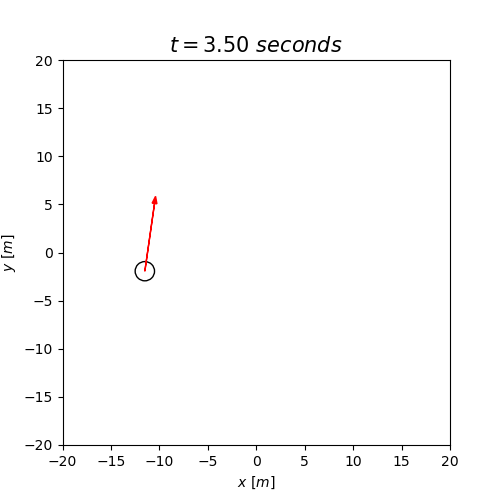

In [6]:
#Solución Inciso 1 parte 2 (Animación)

plt.close()
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)


def init():
    ax.set_xlim(-Limits[0],Limits[0])
    ax.set_ylim(-Limits[1],Limits[1])
    ax.set_xlabel("$x \ [m]$")
    ax.set_ylabel("$y \ [m]$")

def Update(i):
    
    plot = ax.clear()
    init()
    plot = ax.set_title(r'$t=%.2f \ seconds$' %(redt1[i]), fontsize=15)
    
    for p in Particles:
        x = p.GetRPositionVector()[i,0]
        y = p.GetRPositionVector()[i,1]
        
        vx = p.GetRVelocityVector()[i,0]
        vy = p.GetRVelocityVector()[i,1]
        
        circle = plt.Circle( (x,y), p.GetR(), color='k', fill=False)
        plot = ax.add_patch(circle)
        plot = ax.arrow(x,y,vx,vy,color='r',head_width=0.5)
        ax.set_xlabel("$x \ [m]$")
        
        ax.set_ylabel("$y \ [m]$")
    return plot

Animation = anim.FuncAnimation(fig,Update,frames=len(redt1),init_func=init)

In [7]:
# Inciso 01 Parte 03 (Una simulación más exacta).
#Con el fin de ilustrar algunos problemas con el método, se realizará una simulación más precisa. 

dt2 = 0.001
tmax = 30
t2 = np.arange(0,tmax+dt2,dt2)
t = t2
r0 = np.array([-15.,5.])
v0 = np.array([1.,0.])
a0 = np.array([0.,-9.8])
NParticles = 1
Limits = np.array([20.,20.])

dim = 2
Particles2 = RunSimulation(t, NParticles, r0, v0, a0, dim, cond = "1") #Segunda simulación con un dt más pequeño
redt2 = ReduceTime(t2,100, Particles2) # Se aumentó en un factor de 10 la reducción del tiempo con el fin de 
                         # Tener la misma cantidad de posiciones de la primera simulación.

100%|████████████████████████████████████████████████████████████████████████| 30001/30001 [00:00<00:00, 110854.83it/s]


In [8]:
# Tiempo en el cual la pelota deja de rebotar. 
#NOTA!!! Se tomó como criterio que la pelota deja de rebotar en el momento en el cual el cambio en la altura de esta,
# sea 0.01 veces menor a la altura inicial. Adcionalmente, se el cálculo del tiempo de rebote y su resultado.
y1 = Particles[0].GetPositionVector()[:,1]
y2 = Particles2[0].GetPositionVector()[:,1] 
dy1 = y1[:-1] - y1[1:] #Diferencias de altura en cada paso (e.g. dy = [y_i - y_{i+1}])
dy2 = y2[:-1] - y2[1:]

t1r = (dy1 < (r0[1]+20)*0.01)  & (dy1  > 0) & (y1 [1:] < -15) #Se desea buscar cuando la altura de la pelota sea cercana al suelo, así como que el cambio en la altura sea positivo y menor a 0.01 veces la altura inicial.
t2r = (dy2 < (r0[1]+20)*0.01)  & (dy2  > 0)

h = 25
g = 9.8
ee = 0.9
tiempo_teo = (1+ ee)/(1-ee)*np.sqrt(2*h/g)

print("El tiempo teórico esperado corresponde a {:.2f} s. Las simulaciones indicaron que los siguientes tiempos de rebote".format(tiempo_teo))
print("\nSim 1 : {:.2f} s \nSim 2 : {:.2f} s".format(t1[:-1][t1r[:]][0], t2[-1])) #El tiempo de rebote de la segunda simulación se toma como el maximo de la simulacion

El tiempo teórico esperado corresponde a 42.92 s. Las simulaciones indicaron que los siguientes tiempos de rebote

Sim 1 : 18.96 s 
Sim 2 : 30.00 s


<IPython.core.display.Javascript object>


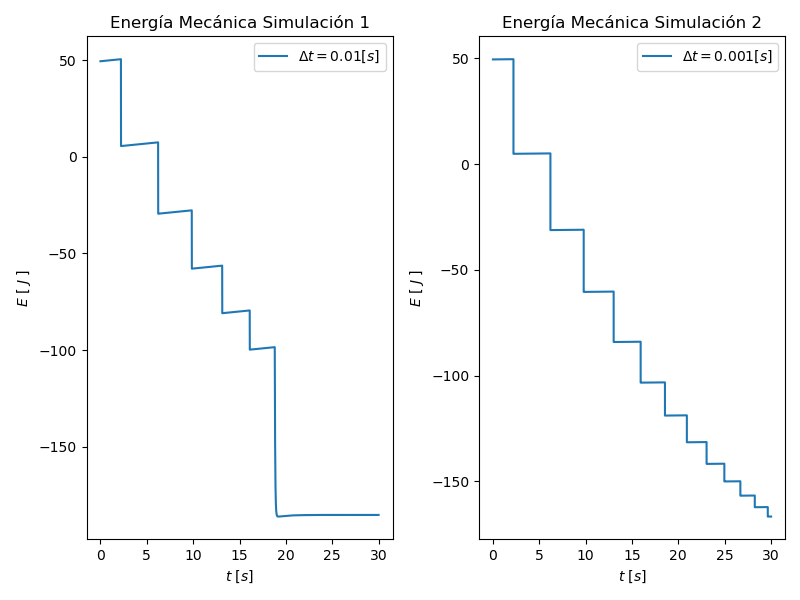

In [10]:
#Inciso 01 Parte 04 (Comparación de las simulaciones y análisis de ellas.)




#Se muestran a continuación las energías mecánicas en ambas simulaciones. 

plt.close() #Detiene la animación de la celda anterior.

KVec= Particles[0].GetKVector()
UVec = Particles[0].GetUVector()
EVec = KVec + UVec

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,2,1)

ax.set_title("Energía Mecánica Simulación 1")
ax.plot(t1, EVec, label = "$\Delta t = 0.01 [s]$" )
ax.set_xlabel("$t \ [s]$")
ax.set_ylabel("$E \  [ \ J \ ]$")
plt.legend()

#Gráfica de la enrgía mecanica de la segunda simulación.
ax2 = fig.add_subplot(1,2,2)

KVec2= Particles2[0].GetKVector()
UVec2 = Particles2[0].GetUVector()
EVec2 = KVec2 + UVec2


ax2.set_title("Energía Mecánica Simulación 2")
ax2.plot(t2, EVec2, label = "$\Delta t = 0.001 [s]$" )
ax2.set_xlabel("$t \ [s]$")
ax2.set_ylabel("$E \  [ \ J \ ]$")
plt.legend()
plt.tight_layout()



# Comentarios acerca el método usado

Al usar un $dt$ más pequeño, los valores obtenidos por medio del método numérico, la posición y la velocidad, son más cercanos a los esperados teóricamente. Se puede notar que la energía mecánica es más cercana a la teórica, debido a que la 
acumulación de error es más baja. Principalmente, se pueden observar dos diferencias importantes en las gráficas mostradas anterioremente. 

Primero, la gráfica de la primera simulación presenta una disminuición súbita de la energia mecánica, la cual no aparece en la segunda simulación, la razón corta de este fenómeno se debe al método, específicamente, este cambio en la energía mecánica se debe a una cadena de errores. Lo primero que sucede es que el método de integración de euler, genera una posición físicamente no permitida, esto dado que se llega a una posición menor a $-19$ **m**, esto se muestra en la siguiente celda de código. Luego, el método que verifica los choques cambia el signo de la velocidad, pero dado que la magnitud de la velocidad no es lo suficientemente grande, esto genera que en el siguiente instante de tiempo, vuelva a cambiar la velocidad de la partícula, generando así el efecto visual de que la partícula no rebote más. 

La segunda diferencia apreciable es que la energía mecánica aumenta entre cada rebote. Esto físicamente no es posible, teniendo en cuenta el modelo físico que se desea simular. De nuevo, esto se debe a errores generados por el método de euler, dado que también se generan posiciones "físicamente" no permitidas, por ejemplo, que la altura que se alcance sea mayor a la esperada teóricamente, como se muestra en la siguiente celda. Los resultados teóricos de este comentario anterior se basan en la siguiente página web: http://www.sc.ehu.es/sbweb/fisica/dinamica/con_mlineal/restitucion/restitucion.htm

In [11]:
yy1 = Particles[0].GetRPositionVector()[:,1]

#Posiciones verticales físicamente prohibidas
t_inv1 = yy1 < -19.01

print("En la simulación 1, el centro de la pelota alcanza una altura de {:.4g} m en el instante {:.3g}0 s".format(yy1[t_inv1][0], redt1[t_inv1][0]))


En la simulación 1, el centro de la pelota alcanza una altura de -19.04 m en el instante 18.90 s


In [12]:
# Solución Inciso 02 Parte 1 (Simulación)
#Datos y condiciones adicionales.
#EN ESTA SOLUCIÓN INICISO SE TOMA EN CUENTA LA CONDICIÓN DE UN VOLUMEN DE 10*10*10 m^3
dt = 0.01
tmax = 30
t = np.arange(0,tmax+dt,dt)
Limits = np.array([10.,10., 10.])
Limit  = Limits[0]
dim = 3
#Se toman en 0s, pero en la función para obtener las particulas se inicializa cada una
r0 = np.zeros(3)
v0 = np.zeros(3)
a0 = np.zeros(3)
NParticles = 100

Particles = RunSimulation(t, NParticles, r0, v0, a0, dim, cond = "2", Velo = 6)
redt = ReduceTime(t,10, Particles)

100%|████████████████████████████████████████████████████████████████████████████| 3001/3001 [00:02<00:00, 1030.36it/s]


<IPython.core.display.Javascript object>


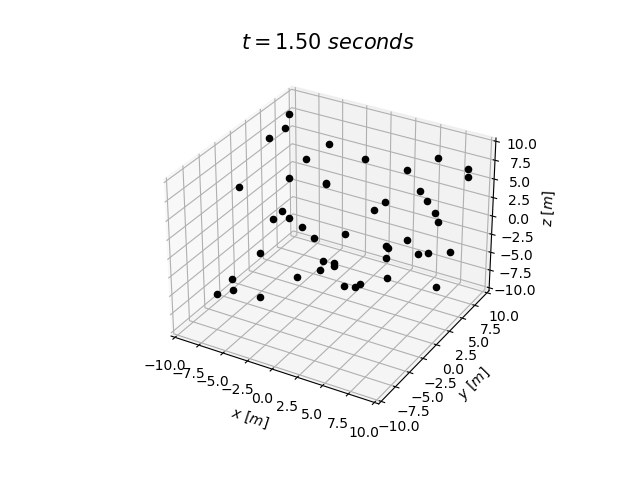

In [13]:
#Solución Inciso 2 parte 2 (Animación y Respuestas)

fig2 = plt.figure()
ax2 = plt.axes(projection='3d')


def init():
    ax2.set_xlim( -Limits[0], Limits[0])
    ax2.set_ylim( -Limits[1], Limits[1])
    ax2.set_zlim( -Limits[2], Limits[2])
    ax2.set_xlabel("$x \ [m]$")
    ax2.set_ylabel("$y \ [m]$")
    ax2.set_zlabel("$z \ [m]$")


def Update(i):
    
    plot = ax2.clear()
    init()
    plot = ax2.set_title(r'$t=%.2f \ seconds$' %(redt[i]), fontsize=15)
    
    for p in Particles:
        x = p.GetRPositionVector()[i,0]
        y = p.GetRPositionVector()[i,1]
        z = p.GetRPositionVector()[i,2]
        
        vx = p.GetRVelocityVector()[i,0]
        vy = p.GetRVelocityVector()[i,1]
        vz = p.GetRVelocityVector()[i,2]
        
        
        plot = ax2.scatter3D(x,y,z, color= "black")
        
        ax2.set_xlabel("$x \ [m]$")
        ax2.set_ylabel("$y \ [m]$")
        ax2.set_zlabel("$z \ [m]$")
    return plot

Animation = anim.FuncAnimation(fig2,Update,frames=len(redt),init_func=init)